# 优化理论与算法 2

__SETUP : 仅运行一次__

In [1]:
%pip install -U scikit-learn
import numpy as np
import sys
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_svmlight_file
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import scipy

In [2]:
K = 1000 #最大迭代次数
eps = 1E-8 #停止条件

__读取文件__

In [3]:
path = r"./dataset/a2a"
A,b = load_svmlight_file(path)

In [4]:
A = A.toarray()
A,b

(array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 array([-1., -1., -1., ..., -1., -1., -1.]))

__设置共同初始点 $\mathrm{x}_{ini}$__

In [5]:
r,c = A.shape
r,c

(2265, 119)

In [6]:
x_ini = np.zeros((1,c))

# Problem 1

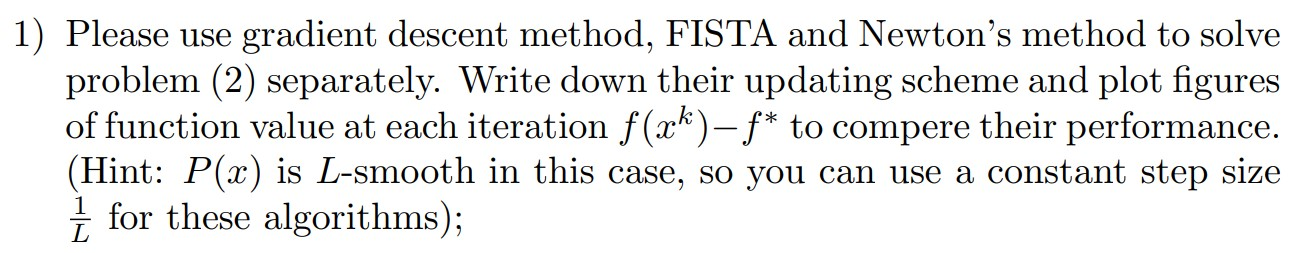

$P(x)=\frac{1}{n} \sum_{i=1}^{n} \log \left(1+\exp \left(-b_{i} \cdot a_{i}^{T} x\right)\right)+\frac{\lambda}{2}\|x\|_{2}^{2}$

计算目标值P

In [7]:
def P1(A,b,x):
    return float(np.log(np.exp(- b.reshape(1,b.shape[0]).T * (A @ x.T))+1).sum() / A.shape[0] + 0.1 / 2 * x @ x.T)

计算当前梯度

In [8]:
def g1(A,b,x):
    d = b.reshape(1,b.shape[0]).T
    t1 = - d * A
    t2 = 1 + np.exp(- d * (A @ x.T))
    t3 = b / t2.T
    t4 = t1 + t3.T * A
    final = t4.sum(axis = 0) / (A.shape[0]) + 0.1 * x
    return final

计算Hessian阵

In [9]:
def gg1(A,b,x):
    d = b.reshape(1,b.shape[0]).T
    t1 = 0.1 * np.eye(x.shape[1])
    
    i = int(A.shape[0] / 10)
    temp_final = np.zeros((1,x.shape[1],x.shape[1]))
    for k in range(10):
        temp_d = d[k*i:(k+1)*i]
        temp_A = A[k*i:(k+1)*i]
        temp_t2 = 1 + np.exp(- temp_d * (temp_A @ x.T))
        temp_t3 = np.square(temp_t2)
        temp_t4 = np.einsum('bi,bo->bio', temp_A, temp_A)
        temp_t5 = temp_t4 / (temp_t2.reshape(temp_t2.shape[0],1,1)) / 2
        temp_t6 = temp_t4 / (temp_t3.reshape(temp_t3.shape[0],1,1)) / 2
        temp_t7 = temp_t5 - temp_t6
        temp_sum = temp_t7.sum(axis = 0)
        temp_final = temp_final + temp_sum
    rest_d = d[10*i:]
    rest_A = A[10*i:] 
    rest_t2 = 1 + np.exp(- rest_d * (rest_A @ x.T))
    rest_t3 = np.square(rest_t2)
    rest_t4 = np.einsum('bi,bo->bio', rest_A, rest_A)
    rest_t5 = rest_t4 / (rest_t2.reshape(rest_t2.shape[0],1,1)) / 2
    rest_t6 = rest_t4 / (rest_t3.reshape(rest_t3.shape[0],1,1)) / 2
    rest_t7 = rest_t5 - rest_t6
    rest_sum = rest_t7.sum(axis = 0)
    temp_final = temp_final + rest_sum
    
    final = temp_final / (A.shape[0]) + t1
    return final

__Algorithm 1 Gradient descent method__  
__1.__&emsp;initial point $x_0$  
__2.__&emsp;$L={\lambda}+\frac{1}{8n}\sum_{i=1}^{n}maxeig({a^T_i}{a_i})$  
__3.__&emsp;__for__ $k=0,1,2,...,$ __do__  
__4.__&emsp;&emsp;&emsp;$\nabla P(x_k)=\frac{1}{n} \sum_{i=1}^{n}\left(-b_{i} a_{i}+\frac{b_{i} a_{i}}{1+e^{-b_{i} a_{i}^{T} x_k}}\right)+\lambda x_k$  
__5.__&emsp;&emsp;&emsp;update $x_{k+1}=x_k-\nabla P(x_k)/L$  
__6.__&emsp;&emsp;&emsp;__if__ $\left\|x^{k+1}-x^{k}\right\|_{2} \leq eps$ __or__ $k \geq K$ __then__  
__7.__&emsp;&emsp;&emsp;&emsp;&emsp;stop  
__8.__&emsp;&emsp;&emsp;__endif__  
__9.__&emsp;__endfor__

In [10]:
def gdm1(A,b,x0,K,eps):
    r,c = A.shape
    x = x0
    x_array = np.zeros((K,c))
    p_array = np.zeros(K,dtype = float)
    try:
        L = (np.linalg.eigvals(np.einsum('bi,bo->bio', A, A)).max(axis = 1).sum() / 8 / A.shape[0] + 0.1).real
        if L <= 10:
            L = 10
    except:
        L = 10
    print("\nstep size = ",1/L)
    cnt = 0
    while cnt < K:
        x_array[cnt] = x
        p = p_array[cnt] = P1(A,b,x)
        g = g1(A,b,x)
        x = x - (g / L)
        if np.linalg.norm(x - x_array[cnt]) <= eps:
            break
        cnt = cnt + 1
    x_star = x_array[cnt-1]
    p_star = p_array[cnt-1]
    error_x = np.log([np.linalg.norm(x - x_star) for x in x_array[0 : cnt-1]])
    error_p = np.log(p_array[0 : cnt-1]-p_star)
    return [x_star,p_star,error_x , error_p, x_array , p_array]

__Algorithm 2 Fista__  
__1.__&emsp;initial point $x_0,x_{-1}$  
__2.__&emsp;$L={\lambda}+\frac{1}{8n}\sum_{i=1}^{n}maxeig({a^T_i}{a_i})$  
__3.__&emsp;__for__ $k=0,1,2,...,$ __do__  
__4.__&emsp;&emsp;&emsp;$\nabla P(x_k)=\frac{1}{n} \sum_{i=1}^{n}\left(-b_{i} a_{i}+\frac{b_{i} a_{i}}{1+e^{-b_{i} a_{i}^{T} x_k}}\right)+\lambda x_k$  
__5.__&emsp;&emsp;&emsp;$y = x_{k} + \frac{k-2}{k+1}(x_{k}-x_{k-1})$  
__6.__&emsp;&emsp;&emsp;update $x_{k+1}=y-\nabla P(x_k)/L$  
__7.__&emsp;&emsp;&emsp;__if__ $\left\|x^{k+1}-x^{k}\right\|_{2} \leq eps$ __or__ $k \geq K$ __then__  
__8.__&emsp;&emsp;&emsp;&emsp;&emsp;stop  
__9.__&emsp;&emsp;&emsp;__endif__  
__10.__&emsp;__endfor__

In [11]:
def fista1(A,b,x0,K,eps):
    r,c = A.shape
    x = x0
    x_old = x0
    x_array = np.zeros((K,c))
    p_array = np.zeros(K)
    try:
        L = (np.linalg.eigvals(np.einsum('bi,bo->bio', A, A)).max(axis = 1).sum() / 8 / A.shape[0] + 0.1).real
        if L <= 10:
            L = 10
    except:
        L = 10
    print("\nstep size = ",1/L)
    cnt = 0
    while cnt < K:
        x_array[cnt] = x
        p_array[cnt] = P1(A,b,x)
        p = p_array[cnt]
        y = x + (cnt - 2) * (x - x_old) / (cnt + 1)
        g = g1(A,b,y)
        x_old = x
        x = y - (g / L)
        if np.linalg.norm(x - x_array[cnt]) <= eps:
            break
        cnt = cnt + 1
    x_star = x_array[cnt-1]
    p_star = p_array[cnt-1]
    error_x = np.log([np.linalg.norm(x - x_star) for x in x_array[0 : cnt-1]])
    error_p = np.log(p_array[0 : cnt-1]-p_star)
    return [x_star,p_star,error_x , error_p, x_array , p_array]

__Algorithm 3 Newton’s method__  
__1.__&emsp;initial point $x_0,x_{-1}$  
__2.__&emsp;$L={\lambda}+\frac{1}{8n}\sum_{i=1}^{n}maxeig({a^T_i}{a_i})$  
__3.__&emsp;__for__ $k=0,1,2,...,$ __do__  
__4.__&emsp;&emsp;&emsp;$\nabla P(x_k)=\frac{1}{n} \sum_{i=1}^{n}\left(-b_{i} a_{i}+\frac{b_{i} a_{i}}{1+e^{-b_{i} a_{i}^{T} x_k}}\right)+\lambda x_k$  
__4.__&emsp;&emsp;&emsp;$\nabla^{2} P(x)=\frac{1}{n} \sum_{i=1}^{n}\left(\frac{b_{i}^{2} a_{i}^{T} a_{i}}{2\left(1+e^{-b_{i} a_{i}^{T} x}\right)}-\frac{b_{i}^{2} a_{i}^{T} a_{i}}{2\left(1+e^{-b_{i} a_{i}^{T} x}\right)^{2}}\right)+\lambda I$  
__6.__&emsp;&emsp;&emsp;$d=-{\nabla^{2} P(x)}^{-1}\nabla P(x_k)$    
__7.__&emsp;&emsp;&emsp;update $x_{k+1}=x_k+d/L$  
__8.__&emsp;&emsp;&emsp;__if__ $\left\|x^{k+1}-x^{k}\right\|_{2} \leq eps$ __or__ $k \geq K$ __then__  
__9.__&emsp;&emsp;&emsp;&emsp;&emsp;stop  
__10.__&emsp;&emsp;&emsp;__endif__  
__11.__&emsp;__endfor__

In [12]:
def newton1(A,b,x0,K,eps):
    r,c = A.shape
    x = x0
    x_array = np.zeros((K,c))
    p_array = np.zeros(K,dtype = float)
    eig_sum = 0
    try:
        L = (np.linalg.eigvals(np.einsum('bi,bo->bio', A, A)).max(axis = 1).sum() / 8 / A.shape[0] + 0.1).real
        if L <= 10:
            L = 10
    except:
        L = 10
    
    print("\nstep size = ",1/L)
    cnt = 0
    while cnt < K:
        x_array[cnt] = x
        p = p_array[cnt] = P1(A,b,x)
        g = g1(A,b,x)
        gg = gg1(A,b,x)
        d = - np.linalg.inv(gg) @ g.T
        d = d.reshape(1,d.shape[1])
        x = x + d / L
        if np.linalg.norm(x - x_array[cnt]) <= eps:
            break
        cnt = cnt + 1
    x_star = x_array[cnt-1]
    p_star = p_array[cnt-1]
    error_x = np.log([np.linalg.norm(x - x_star) for x in x_array[0 : cnt-1]])
    error_p = np.log(p_array[0 : cnt-1]-p_star)
    return [x_star,p_star,error_x , error_p, x_array , p_array]

In [13]:
error_gdm1 = gdm1(A,b,x_ini,K,eps)
error_fista1 = fista1(A,b,x_ini,K,eps)


step size =  0.1

step size =  0.1


In [14]:
if path == r"./dataset/w8a":
    print("Dataset : w8a 计算超时")
else:
    error_newton1 = newton1(A,b,x_ini,K,eps)


step size =  0.1


__最优值__

In [15]:
error_gdm1[1],error_fista1[1],error_newton1[1]

(0.4854219238204257, 0.48542192381997007, 0.4854219238199368)

__比较分析__

In [16]:
p_gdm1 = error_gdm1[3]
p_fista1 = error_fista1[3]
p_newton1 = error_newton1[3]

x_min = min(p_gdm1.size,p_fista1.size,p_newton1.size)
x_array = np.arange(x_min)

p_gdm1 = p_gdm1[:x_min]
p_fista1 = p_fista1[:x_min]
p_newton1 = p_newton1[:x_min]

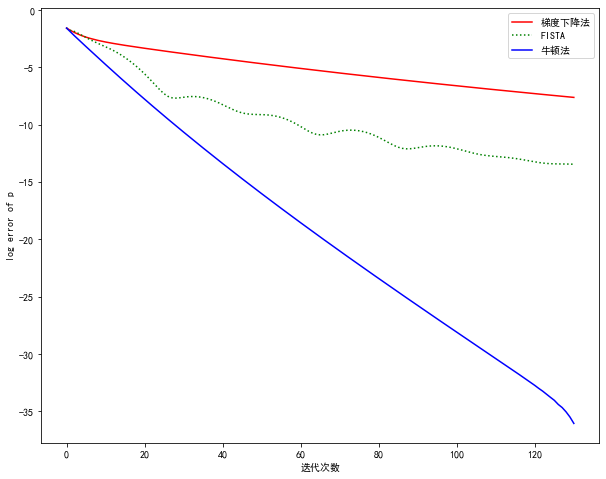

In [17]:
matplotlib.rcParams['font.family']='SimHei'
matplotlib.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(10,8))
plt.plot(x_array,p_gdm1,"r",x_array,p_fista1,"g:",x_array,p_newton1,"b")
plt.xlabel("迭代次数")
plt.ylabel("log error of p")
plt.legend(["梯度下降法","FISTA","牛顿法"])

# Problem 2

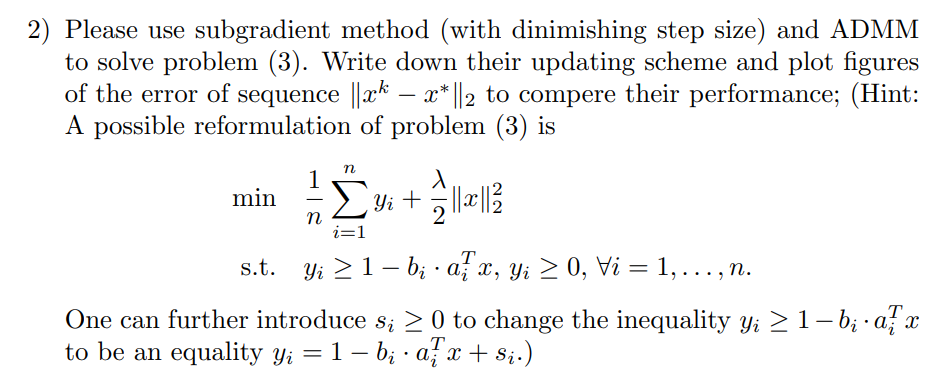

$P(x)=\frac{1}{n} \sum_{i=1}^{n}\left[1-b_{i} \cdot a_{i}^{T} x\right]_{+}+\frac{\lambda}{2}\|x\|_{2}^{2}$

计算目标值P

In [18]:
def P2(A,b,x):
    t0 = 0.1 / 2 * x @ x.T
    d = b.reshape(1,b.shape[0]).T
    t1 = 1 - d * (A @ x.T)
    t2 = np.clip(t1,0,None)
    return float(t2.sum() / A.shape[0] + 0.1 / 2 * x @ x.T)

计算当前次梯度

In [19]:
def sg2(A,b,x):
    d = b.reshape(1,b.shape[0]).T
    bench = d * (A @ x.T)
    t1 = - d * A 
    flag = (bench >= 1)
    flag = flag. ravel()
    t1[flag] = 0
    t2 = t1.sum(axis = 0).reshape(1,A.shape[1]) / A.shape[0]
    final = t2 + 0.1 * x
    return final

计算admm各更新值

In [20]:
def admm_p(y,x):
    r = y.shape[1]
    t1 = y.sum() / r
    t2 = 0.1 / 2 * x @ x.T
    return float(y.sum() / r + 0.1 / 2 * x @ x.T)

In [21]:
def admm_x(t,A,s,y,lamd):
    r,c = A.shape
    t0 = 0.1 * np.eye(c)
    t1 = t * (A.T @ A)
    t2 = t * np.linalg.inv(t0 + t1)
    t3 = t2 @ A.T
    t4 = np.ones((1,r)) + s + lamd / t - y
    final = t3 @ t4.T
    final = final.reshape((1,c))
    return final

In [22]:
def admm_y(t,A,s,x,lamd):
    r,c = A.shape
    t0 = np.ones((1,r)) 
    t1 = A @ x.T
    t1 = t1.reshape((1,r))
    final = t0 - t1 + s + lamd / t - (t / r)
    return final

In [23]:
def admm_s(t,A,x,y,lamd):
    r,c = A.shape
    t0 = A @ x.T
    t0 = t0.reshape((1,r))
    t1 = y - np.ones((1,r)) + t0 - lamd / t
    final = np.clip(t1,0,None)
    return final

In [24]:
def admm_lamd(t,A,x,y,s,lamd):
    r,c = A.shape
    t0 = np.ones((1,r))
    t1 = A @ x.T
    t1 = t1.reshape((1,r))
    t3 = t * (y - t0 + t1 - s)
    final = lamd - t3
    return final

__Algorithm 1 Subgradient method__  
__1.__&emsp;initial point $x_0$  
__2.__&emsp;__for__ $k=0,1,2,...,$ __do__  
__3.__&emsp;&emsp;&emsp;$\partial P(x_k)= \begin{cases}\frac{1}{n} \sum_{i=1}^{n}\left(-b_{i} a_{i}\right)+\lambda x_k & \text { if } b_{i} a_{i}^{T} x_k<1 \\ \lambda x_k & \text { if } b_{i} a_{i}^{T} x_k \geq 1\end{cases}$  
__4.__&emsp;&emsp;&emsp;update $x_{k+1}=x_k-\partial P(x_k)/(k+1)$  
__5.__&emsp;&emsp;&emsp;__if__ $\left\|x^{k+1}-x^{k}\right\|_{2} \leq eps$ __or__ $k \geq K$ __then__  
__6.__&emsp;&emsp;&emsp;&emsp;&emsp;stop  
__7.__&emsp;&emsp;&emsp;__endif__  
__8.__&emsp;__endfor__

In [25]:
def sgm2(A,b,x0,K,eps):
    r,c = A.shape
    x = x0
    x_array = np.zeros((K,c))
    p_array = np.zeros(K,dtype = float)
    cnt = 0
    while cnt < K:
        x_array[cnt] = x
        p = p_array[cnt] = P2(A,b,x)
        g = sg2(A,b,x)
        x = x - (g / (cnt + 1))
        if np.linalg.norm(x - x_array[cnt]) <= eps:
            break
        cnt = cnt + 1
    x_star = x_array[cnt-1]
    p_star = p_array[cnt-1]
    error_x = np.log([np.linalg.norm(x - x_star) for x in x_array[0 : cnt-1]])
    error_p = np.log(p_array[0 : cnt-1]-p_star)
    if cnt == K:
        error_x =error_x[:int(0.6*K)+1]
        error_p =error_p[:int(0.6*K)+1]
        x_array = x_array[:int(0.6*K)+1]
        p_array = p_array[:int(0.6*K)+1]
    return [x_star,p_star,error_x , error_p, x_array , p_array]

__Algorithm 2 ADMM__  

In [26]:
def admm2(A,b,x0,K,eps):
    r,c = A.shape
    A = b.reshape(1,b.shape[0]).T * A
    x = x0
    s = np.random.uniform(0,1,size=(1,r))
    y = np.random.uniform(0,1,size=(1,r))
    lamd = np.random.uniform(0,1,size=(1,r))
    t = 0.0001
    x_array = np.zeros((K,c))
    p_array = np.zeros(K,dtype = float)
    cnt = 0
    while cnt < K:
        x_array[cnt] = x
        x = admm_x(t,A,s,y,lamd)
        y = admm_y(t,A,s,x,lamd)
        p = p_array[cnt] = admm_p(y,x)
        s = admm_s(t,A,x,y,lamd)
        lamd = admm_lamd(t,A,x,y,s,lamd)
        if np.linalg.norm(x - x_array[cnt]) <= eps :
            break
        cnt = cnt + 1
    x_star = x_array[cnt-1]
    p_star = p_array[cnt-1]
    error_x = np.log([np.linalg.norm(x - x_star) for x in x_array[0 : cnt-1]])
    error_p = np.log(p_array[0 : cnt-1]-p_star)
    if cnt == K:
        error_x =error_x[:int(0.6*K)+1]
        error_p =error_p[:int(0.6*K)+1]
        x_array = x_array[:int(0.6*K)+1]
        p_array = p_array[:int(0.6*K)+1]
    return [x_star,p_star,error_x , error_p, x_array , p_array]

In [27]:
error_sgm2 = sgm2(A,b,x_ini,K,eps)

In [28]:
error_admm2 = admm2(A,b,x_ini,K,eps)

__最优值__

In [29]:
error_sgm2[1],error_admm2[1]

(0.48415316325999685, 1.5049441101088825)

__比较分析__

In [30]:
p_sgm2 = error_sgm2[2]
p_admm2 = error_admm2[2]


x_min = min(p_sgm2.size,p_admm2.size)
x_array = np.arange(x_min)

p_sgm2 = p_sgm2[:x_min]
p_admm2 = p_admm2[:x_min]

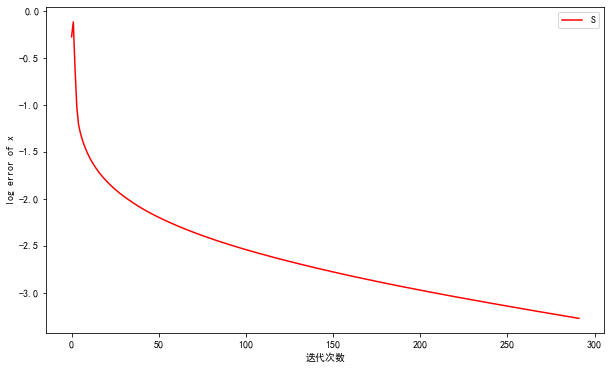

In [31]:
plt.figure(figsize=(10,6))
plt.plot(x_array,p_sgm2,"r")
plt.xlabel("迭代次数")
plt.ylabel("log error of x")
plt.legend("Subgradient")

# Problem 3

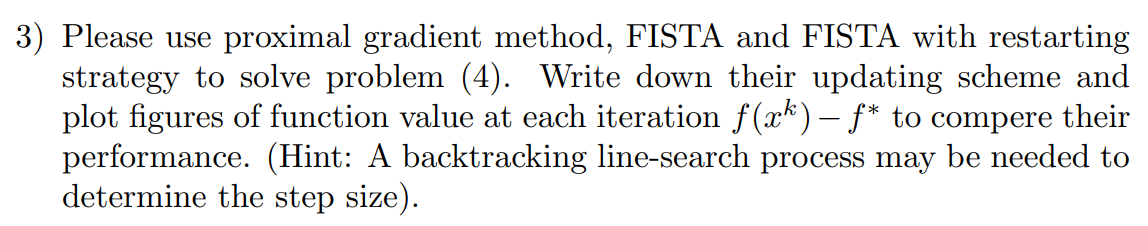

$P(x)=\frac{1}{n} \sum_{i=1}^{n}\left(\left[1-b_{i} \cdot a_{i}^{T} x\right]_{+}\right)^{2}+\frac{\lambda}{2}\|x\|_{1}$

$g(x)=\frac{1}{n} \sum_{i=1}^{n}\left(\left[1-b_{i} \cdot a_{i}^{T} x\right]_{+}\right)^{2}$  
$h(x)=\frac{\lambda}{2}\|x\|_{1}$

计算当前目标值P

In [32]:
def P3(A,b,x):
    t0 = 0.1 / 2 * x @ x.T
    d = b.reshape(1,b.shape[0]).T
    t1 = 1 - d * (A @ x.T)
    t2 = np.clip(t1,0,None)
    t3 = np.square(t2)
    t4 = 0.1/2 * np.linalg.norm(x,1)
    return float(t3.sum() / A.shape[0] + t4)

计算当前可导函数值g

In [33]:
def g3(A,b,x):
    t0 = 0.1 / 2 * x @ x.T
    d = b.reshape(1,b.shape[0]).T
    t1 = 1 - d * (A @ x.T)
    t2 = np.clip(t1,0,None)
    t3 = np.square(t2)
    return float(t3.sum() / A.shape[0])

计算当前函数g的梯度

In [34]:
def sg3(A,b,x):
    d = b.reshape(1,b.shape[0]).T
    bench = d * (A @ x.T)
    t1 = -2 * d * A
    t2 = 1 - d * (A @ x.T)
    t3 = t1 * t2
    flag = (bench >= 1)
    flag = flag. ravel()
    t3[flag] = 0
    t4 = t3.sum(axis = 0).reshape(1,A.shape[1]) / A.shape[0]
    final = t4
    return final

计算$\operatorname{prox}_{\frac{t\lambda}{2}\|x\|_{1}}$

In [35]:
def pm3(x,t):
    flag1 = (x <= 0.05*t)
    flag2 = (x >= -0.05*t)
    x[np.logical_and(flag1,flag2)] = 0
    x[x > 0.05*t] = x[x > 0.05*t] - 0.05*t
    x[x < -0.05*t] = x[x < -0.05*t] + 0.05*t
    return x

__Algorithm 1 proximal gradient method__  
__1.__&emsp;initial point $x_0$   
__2.__&emsp;__for__ $k=0,1,2,...,$ __do__  
__3.__&emsp;&emsp;&emsp;$t=1$  
__4.__&emsp;&emsp;&emsp;$\partial g(x)=\left\{\begin{array}{cc}\frac{1}{n} \sum_{i=1}^{n}\left(-2 b_{i} a_{i}\left(1-b_{i} \cdot a_{i}^{T} x\right)\right) & \text { if } b_{i} a_{i}^{T} x<1 \\ 0 & \text { if } b_{i} a_{i}^{T} x \geq 1\end{array}\right.$  
__5.__&emsp;&emsp;&emsp;update $x_{k+1}=\operatorname{prox}_{\frac{\lambda}{2}\|x\|_{1}}(x_k-t\partial P(x_k))$  
__6.__&emsp;&emsp;&emsp;__while__ $ g(x_{k+1}) > g(x_k) + \nabla g(x)^T (x_{k+1}-x_k) + \frac{1}{2t}\|x_{k+1}-x_k\|_{2}^{2} $  
__7.__&emsp;&emsp;&emsp;&emsp;&emsp;$t = \beta t$  
__8.__&emsp;&emsp;&emsp;&emsp;&emsp;$x_{k+1}=\operatorname{prox}_{\frac{\lambda}{2}\|x\|_{1}}(x_k-t\partial P(x_k))$  
__9.__&emsp;&emsp;&emsp;__if__ $\left\|x^{k+1}-x^{k}\right\|_{2} \leq eps$ __or__ $k \geq K$ __then__  
__10.__&emsp;&emsp;&emsp;&emsp;&emsp;stop  
__11.__&emsp;&emsp;&emsp;__endif__  
__12.__&emsp;__endfor__

In [36]:
def pgm3(A,b,x0,K,eps):
    r,c = A.shape
    x = x0
    x_old = x0
    x_array = np.zeros((K,c))
    p_array = np.zeros(K,dtype = float)
    cnt = 0
    t0 = 1
    while cnt < K:
        t = t0
        g = sg3(A,b,x)
        x_old = np.copy(x)
        x = pm3(x_old - t*g,t)
        while g3(A,b,x) > g3(A,b,x_old) + sg3(A,b,x_old) @ (x - x_old).T + 0.5 / t * (x - x_old) @ (x - x_old).T:
            t = 0.8 * t
            x = pm3(x_old - t*g,t)
        x_array[cnt] = x
        p_array[cnt] = P3(A,b,x)
        if np.linalg.norm(x - x_old) <= eps or (abs(P3(A,b,x) - P3(A,b,x_old))/abs(P3(A,b,x)) < eps):
            break
        cnt = cnt + 1
    
    x_star = x_array[cnt-1]
    p_star = p_array[cnt-1]
    error_x = np.log([np.linalg.norm(x - x_star) for x in x_array[0 : cnt-1]])
    error_p = np.log(p_array[0 : cnt-1]-p_star)
    
    if cnt == K:
        error_x =error_x[:int(0.6*K)+1]
        error_p =error_p[:int(0.6*K)+1]
        x_array = x_array[:int(0.6*K)+1]
        p_array = p_array[:int(0.6*K)+1]
    return [x_star,p_star,error_x , error_p, x_array , p_array]

__Algorithm 2 FISTA__  
__1.__&emsp;initial point $x_0$   
__2.__&emsp;__for__ $k=0,1,2,...,$ __do__  
__3.__&emsp;&emsp;&emsp;$t = 1$  
__4.__&emsp;&emsp;&emsp;$\partial g(x)=\left\{\begin{array}{cc}\frac{1}{n} \sum_{i=1}^{n}\left(-2 b_{i} a_{i}\left(1-b_{i} \cdot a_{i}^{T} x\right)\right) & \text { if } b_{i} a_{i}^{T} x<1 \\ 0 & \text { if } b_{i} a_{i}^{T} x \geq 1\end{array}\right.$  
__5.__&emsp;&emsp;&emsp;$y = x_{k} + \frac{k-2}{k+1}(x_{k}-x_{k-1})$  
__6.__&emsp;&emsp;&emsp;update $x_{k+1}=\operatorname{prox}_{\frac{t\lambda}{2}\|x\|_{1}}(x_k-t\partial P(y))$  
__7.__&emsp;&emsp;&emsp;__while__ $ g(x_{k+1}) > g(x_k) + \nabla g(x)^T (x_{k+1}-x_k) + \frac{1}{2t}\|x\|_{2}^{2} $  
__8.__&emsp;&emsp;&emsp;&emsp;&emsp;$t = \beta t$  
__9.__&emsp;&emsp;&emsp;&emsp;&emsp;$x_{k+1}=\operatorname{prox}_{\frac{\lambda}{2}\|x\|_{1}}(x_k-t\partial P(y))$  
__10.__&emsp;&emsp;&emsp;__if__ $\left\|x^{k+1}-x^{k}\right\|_{2} \leq eps$ __or__ $k \geq K$ __then__  
__11.__&emsp;&emsp;&emsp;&emsp;&emsp;stop  
__12.__&emsp;&emsp;&emsp;__endif__  
__13.__&emsp;__endfor__

In [37]:
def fista3(A,b,x0,K,eps):
    r,c = A.shape
    x = x0
    x_old = x0
    x_array = np.zeros((K,c))
    p_array = np.zeros(K,dtype = float)
    cnt = 0
    t0 = 1
    while cnt < K:
        t = t0
        y = x + (cnt - 2) * (x - x_old) / (cnt + 1)
        g = sg3(A,b,y)
        x_old = np.copy(x)
        x = pm3(y - t*g,t)
        while g3(A,b,x) > g3(A,b,y) + sg3(A,b,y) @ (x - y).T + 0.5 / t * (x - y) @ (x - y).T:
            t = 0.8 * t
            x = pm3(y - t*g,t)
        
        x_array[cnt] = x
        p_array[cnt] = P3(A,b,x)
        if np.linalg.norm(x - x_old) <= eps or (abs(P3(A,b,x) - P3(A,b,x_old))/abs(P3(A,b,x)) < eps):
            break
        cnt = cnt + 1
    x_star = x_array[cnt-1]
    p_star = p_array[cnt-1]
    error_x = np.log([np.linalg.norm(x - x_star) for x in x_array[0 : cnt-1]])
    error_p = np.log(p_array[0 : cnt-1]-p_star)
    if cnt == K:
        error_x =error_x[:int(0.6*K)+1]
        error_p =error_p[:int(0.6*K)+1]
        x_array = x_array[:int(0.6*K)+1]
        p_array = p_array[:int(0.6*K)+1]
    return [x_star,p_star,error_x , error_p, x_array , p_array]

__Algorithm 3 FISTA with restarting strategy__  
__1.__&emsp;initial point $x_0$   
__2.__&emsp;__for__ $k=0,1,2,...,$ __do__  
__3.__&emsp;&emsp;&emsp;$t=1$  
__4.__&emsp;&emsp;&emsp;$\partial g(x)=\left\{\begin{array}{cc}\frac{1}{n} \sum_{i=1}^{n}\left(-2 b_{i} a_{i}\left(1-b_{i} \cdot a_{i}^{T} x\right)\right) & \text { if } b_{i} a_{i}^{T} x<1 \\ 0 & \text { if } b_{i} a_{i}^{T} x \geq 1\end{array}\right.$  
__5.__&emsp;&emsp;&emsp;$y = x_{k} + \frac{kt-2}{kt+1}(x_{k}-x_{k-1})$  
__6.__&emsp;&emsp;&emsp;update $x_{k+1}=\operatorname{prox}_{\frac{t\lambda}{2}\|x\|_{1}}(x_k-t\partial P(y))$  
__7.__&emsp;&emsp;&emsp;__if__ $k > 50$  
__8.__&emsp;&emsp;&emsp;&emsp;&emsp;$kt=0$  
__9.__&emsp;&emsp;&emsp;__else__ $k=kt+1$  
__10.__&emsp;&emsp;&emsp;__while__ $ g(x_{k+1}) > g(x_k) + \nabla g(x)^T (x_{k+1}-x_k) + \frac{1}{2t}\|x\|_{2}^{2} $  
__11.__&emsp;&emsp;&emsp;&emsp;&emsp;$t = \beta t$  
__12.__&emsp;&emsp;&emsp;&emsp;&emsp;$x_{k+1}=\operatorname{prox}_{\frac{\lambda}{2}\|x\|_{1}}(x_k-t\partial P(y))$  
__13.__&emsp;&emsp;&emsp;__if__ $\left\|x^{k+1}-x^{k}\right\|_{2} \leq eps$ __or__ $k \geq K$ __then__  
__14.__&emsp;&emsp;&emsp;&emsp;&emsp;stop  
__15.__&emsp;&emsp;&emsp;__endif__  
__16.__&emsp;__endfor__

In [38]:
def fista_restart3(A,b,x0,K,eps):
    r,c = A.shape
    x = x0
    x_old = x0
    x_array = np.zeros((K,c))
    p_array = np.zeros(K,dtype = float)
    cnt = 0
    kt = 0
    t0 = 1
    while cnt < K:
        t = t0
        y = x + (kt - 2) * (x - x_old) / (kt + 1)
        x_old = np.copy(x)
        g = sg3(A,b,y)
        x = pm3(y - t*g,t)
        while g3(A,b,x) > g3(A,b,y) + sg3(A,b,y) @ (x - y).T + 0.5 / t * (x - y) @ (x - y).T:
            t = 0.8 * t
            x = pm3(y - t*g,t)
        if kt > 50:
            kt = 0
        else:
            kt = kt + 1
        
        x_array[cnt] = x
        p_array[cnt] = P3(A,b,x)
        if np.linalg.norm(x - x_old) <= eps or (abs(P3(A,b,x) - P3(A,b,x_old))/abs(P3(A,b,x)) <= eps):
            break
        cnt = cnt + 1
    
    x_star = x_array[cnt-1]
    p_star = p_array[cnt-1]
    error_x = np.log([np.linalg.norm(x - x_star) for x in x_array[0 : cnt-1]])
    error_p = np.log(p_array[0 : cnt-1]-p_star)
    if cnt == K:
        error_x =error_x[:int(0.6*K)+1]
        error_p =error_p[:int(0.6*K)+1]
        x_array = x_array[:int(0.6*K)+1]
        p_array = p_array[:int(0.6*K)+1]
    return [x_star,p_star,error_x , error_p, x_array , p_array]

In [39]:
error_fista_restart3 = fista_restart3(A,b,x_ini,K,eps)

In [40]:
error_fista3 = fista3(A,b,x_ini,K,eps)

In [41]:
error_pgm3 = pgm3(A,b,x_ini,K,eps)

__最优值__

In [42]:
error_pgm3[1],error_fista3[1],error_fista_restart3[1]

(0.5466336802833948, 0.546632119673554, 0.5466334520944482)

__比较分析__

In [43]:
p_pgm3 = error_pgm3[2]
p_fista3 = error_fista3[2]
p_fista_restart3 = error_fista_restart3[2]

x_min = min(p_pgm3.size,p_fista3.size,p_fista_restart3.size)
x_array = np.arange(x_min)

p_pgm3 = p_pgm3[:x_min]
p_fista3 = p_fista3[:x_min]
p_fista_restart3 = p_fista_restart3[:x_min]

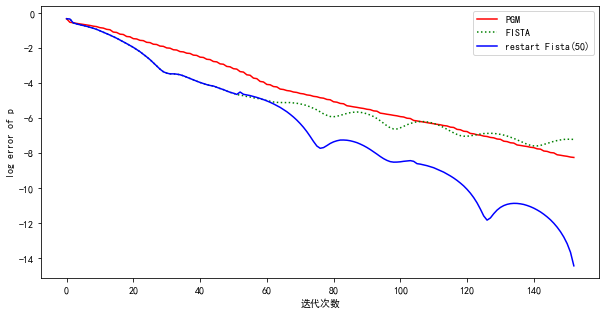

In [44]:
matplotlib.rcParams['font.family']='SimHei'
matplotlib.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(10,5))
plt.plot(x_array,p_pgm3,"r",x_array,p_fista3,"g:",x_array,p_fista_restart3,"b")
plt.xlabel("迭代次数")
plt.ylabel("log error of p")
plt.legend(["PGM","FISTA","restart Fista(50)"])